# A股数据分析

  **通过对A股数据可视化，通过沪深A股的行情数据和一些技术指标的观察研究，制定 选股策略（分类/预测/业务因子），通过算法预测走势，最后制定交易策略完成仿真回测研究**
  
 # 具体操作流程如下：
 
1. 数据获取
2. 预处理
3. 可视化观察
4. 选股
- 选取指标
- 特征提取
- 制定选股策略
- 完成选股

5. 预测走势
- 选取数据
- 预处理
- 多个预测算法尝试
- 评估算法效果
- 结果可视化

6、交易策略
- 历史+预测生成Baseline
- 制定选股策略
- 仿真回测
- 评估效果

7、场景应用

# 1、数据获取

使用  **baostock**
链接：http://baostock.com/baostock/index.php/Python_API%E6%96%87%E6%A1%A3

In [ ]:
import baostock as bs
import pandas as pd
import os
import datetime

def mkdir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print('success makedir')

class Downloader(object):
    def __init__(self,
                 output_dir,
                 date_start='1990-01-01'):
        # 初始化，连接服务
        self._bs = bs
        bs.login()
        # 开始日期
        self.date_start = date_start   
        # 结束日期
        self.date_end = datetime.datetime.now().strftime("%Y-%m-%d")
        # 获取股票code的日期
        self.date_check_code = '2023-09-28'
        # 输出文件夹
        self.output_dir = output_dir
        # 获取数据字段（列名）
        self.fields = "date,code,open,high,low,close,volume,amount," \
                      "adjustflag,turn,tradestatus,pctChg,peTTM," \
                      "pbMRQ,psTTM,pcfNcfTTM,isST"

    def exit(self):
        # 退出服务
        bs.logout()

    def get_codes_by_date(self, date):
        # 查询所有的股票代码
        stock_rs = bs.query_all_stock(date)
        stock_df = stock_rs.get_data()
        print(stock_df)
        return stock_df

    def run(self):
        # 主程序
        # 1、获取股票 code
        stock_df = self.get_codes_by_date(self.date_check_code)
        # 遍历查询每一个 code
        for index, row in stock_df.iterrows():
            # 不要北京交易所的数据
            if 'bj' in row["code"]:
                continue
            print(f'processing {row["code"]} {row["code_name"]}')
            # 获取股票数据
            df_code = bs.query_history_k_data_plus(row["code"], self.fields,
                                                   start_date=self.date_start,
                                                   end_date=self.date_end).get_data()
            # 导出为 csv
            df_code.to_csv(f'{self.output_dir}/{row["code"]}.{row["code_name"]}.csv', index=False)
        self.exit()

if __name__ == '__main__':
    # 获取全部股票的日K线数据
    mkdir('./stockdata/')
    OUTPUT = './stockdata'
    downloader = Downloader('./stockdata', date_start='2000-01-01')
    downloader.run()

## 结果输出如下图
![jupyter](./1.png)

最后在本地生成文件夹：'./stockdata'
里面保存一个个下载的 csv文件

# 2、预处理

./stockdata


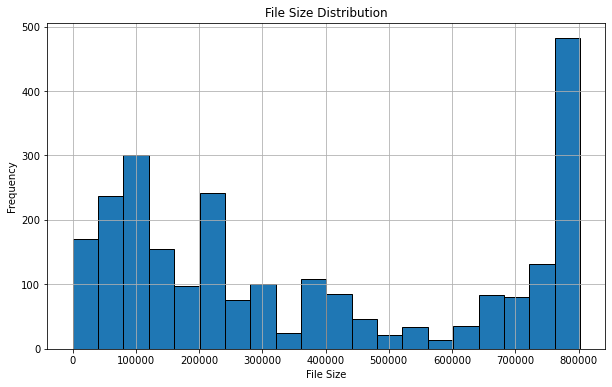

合并完成。


<Figure size 432x288 with 0 Axes>

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import threading

class Combined():
    def __init__(self):
        self.folder_path = './stockdata'
        self.combined_csv_path = './combined.csv'
        self.lock = threading.Lock()  # 在构造函数中定义 lock 变量

    def get_size(self):
        # 指定文件夹路径
        print(self.folder_path)
        folder_path = self.folder_path

        # 获取文件夹内所有文件的信息
        file_info = []
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            if os.path.isfile(file_path):
                # 获取文件大小（以字节为单位）
                file_size_bytes = os.path.getsize(file_path)
                file_info.append({'Filename': filename, 'Size': file_size_bytes})

        # 将信息转换为DataFrame
        file_info_df = pd.DataFrame(file_info)
        file_info_df = file_info_df[file_info_df['Size'] >= 100]
        return file_info_df

    def combine_csv(self,df):
        # 文件夹路径
        folder_path = self.folder_path
        output_file = self.combined_csv_path
        # 创建一个锁，以确保线程安全
        # 合并CSV文件的函数
        def merge_csv(file):
            df = pd.read_csv(os.path.join(folder_path, file))
            with self.lock:
                df.to_csv(output_file, mode='a', header=False, index=False)
        # 创建线程列表
        threads = []
        # 创建并启动线程
        for index, row in df.iterrows():
            file = row['Filename']
            thread = threading.Thread(target=merge_csv, args=(file,))
            threads.append(thread)
            thread.start()

        # 等待所有线程完成
        for thread in threads:
            thread.join()

        print("合并完成。")


    def plot_hist(self,df):
        # 按文件大小排序
        sorted_df = df.sort_values(by='Size', ascending=False)
        # 绘制直方图
        plt.figure(figsize=(10, 6))
        plt.hist(sorted_df['Size'], bins=20, edgecolor='k')
        plt.title('File Size Distribution')
        plt.xlabel('File Size')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()
        plt.savefig('./File_size_distributing.png')




    def run(self):
        # 1、排除空文件
        df = self.get_size()
        # 观察文件大小 画图,观察分布
        self.plot_hist(df)
        # 删除空的文文件:  rm ./bj.*
        # 切割 code 及对应的 name
        # df[['jy','code_num', 'name']] = df['Filename'].str.split('.', expand=True)[[0,1, 2]]
        # df['code'] = df['jy'].astype(str) + '.' + df['code_num'].astype(str)
        # 2、多线程合并成一个csv，便于读取
        self.combine_csv(df)



if __name__ == '__main__':
    main= Combined()
    main.run()